# 18기 Time Series 정규세션 과제

## 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 데이터 불러오기

In [5]:
train = pd.read_csv('./Electric_Production.csv')
train.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


y
(
t
)
=
g
(
t
)
+
s
(
t
)
+
h
(
t
)
+
ϵ
i

g
(
t
)
 : piecewise linear or logistic growth curve for modelling non-periodic changes in time series

s
(
t
)
 : periodic changes (e.g. weekly/yearly seasonality)

h
(
t
)
 : effects of holidays (user provided) with irregular schedules
 
ϵ
i
: error term accounts for any unusual changes not accommodated by the model

위에서 Trend 를 구성하는 
g
(
t
)
 함수는 주기적이지 않은 변화인 트렌드를 나타냅니다. 부분적으로 선형 또는 logistic 곡선으로 이루어져 있습니다. 그리고 Seasonality 인 
s
(
t
)
 함수는 weekly, yearly 등 주기적으로 나타나는 패턴들을 포함합니다.

Holiday를 나타내는 
h
(
t
)
 함수는 휴일과 같이 불규칙한 이벤트들을 나타냅니다. 만약 특정 기간에 값이 비정상적으로 증가 또는, 감소했다면, holiday로 정의하여 모델에 반영할 수 있습니다. 마지막으로 
ϵ
i
 는 정규분포라고 가정한 오차입니다.

In [7]:
train["DATE"]=pd.to_datetime(train["DATE"],infer_datetime_format=True)

In [8]:
train=train.set_index(['DATE'])

In [9]:
train.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


트랜드와 계절성을 고려할 수 있다.
보다 정확한 개연성을 찾아보기 위해서 이 두개를 나눠보았다.

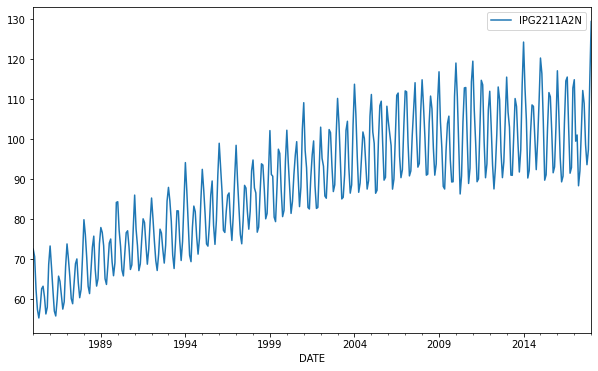

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6
train.plot()

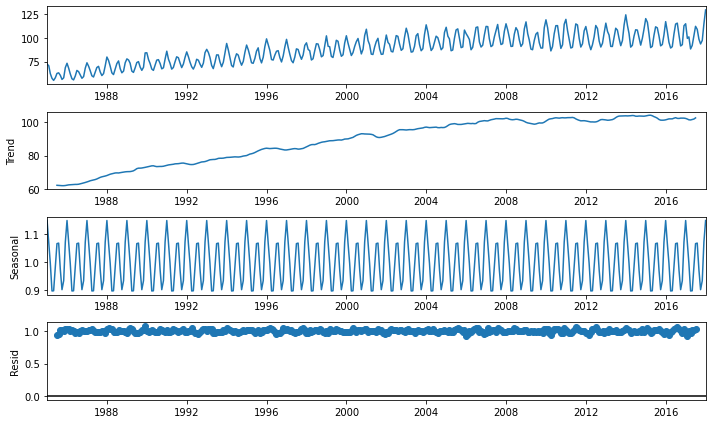

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
res= seasonal_decompose(train, model='multiplicative')
res.plot()
plt.show()

분명 증가하는 추세를 보인다.
자세한 분석을 위해 초반 100개 데이터를 분석해보겠다.

In [12]:
train["IPG2211A2N"].iloc[:100]

DATE
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
               ...   
1992-12-01    84.5159
1993-01-01    87.9464
1993-02-01    84.5561
1993-03-01    79.4747
1993-04-01    71.0578
Name: IPG2211A2N, Length: 100, dtype: float64

우리는 매년 1월에 전기 생산량이 증가한다는 것을 알 수 있다.
그리고 이러한 특징은 계절성을 띈다.

0. 시계열 분석에서 데이터가 stationary한 조건이 필요함

1. 수학적 평균이 일정하고 표준 편차가 일정하며 상관 값이 동일조건 

2. adfuller test를 통해  p-value값이 식별자로 사용  p-value > 0.05 = 비정상

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def stest(x):
    result = adfuller(x)
    print(result[1])

In [15]:
stest(train.iloc[:,0].values)

0.18621469116587053


트랜드를 제거하기 위해서는 전체 구간의 값을 일정하게 만드는 과정이 아닌 구간의 하위에 평균이 같아야하는 것이다.

In [16]:
len(train)

397

In [17]:
a=[]
a.append(train["IPG2211A2N"].iloc[0])
for i in range(396):
     z=train["IPG2211A2N"].iloc[i+1]-train["IPG2211A2N"].iloc[i]
     a.append(z)

In [18]:
a[:5]

[72.5052, -1.833200000000005, -8.221799999999995, -4.9788, -2.1563000000000017]

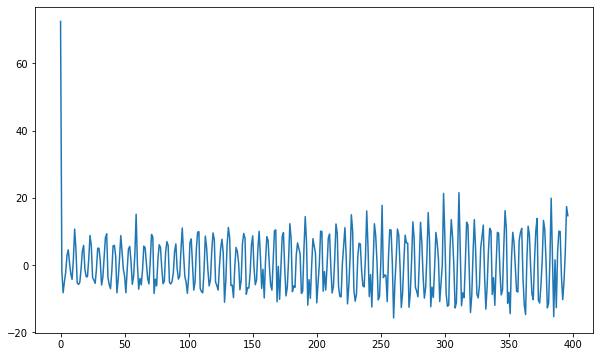

In [19]:
plt.plot(a)

In [20]:
stest(a)

3.145492187838964e-09


0.05 > 0.00003875068 

data가 정지된 상태


In [21]:
t=train["IPG2211A2N"].to_dict()
x={}
l=0
for i,j in t.items():
       x.update({i:a[l]})
       l=l+1

In [22]:
xe=pd.Series(x)

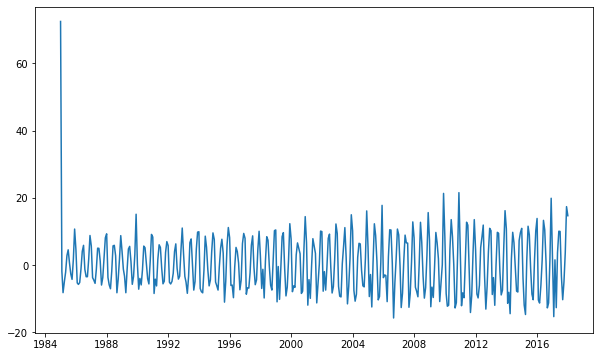

In [23]:
plt.plot(xe)

auto regression : 단순히 현재 값은 이전 시간의 순간에 따라 달라진다.

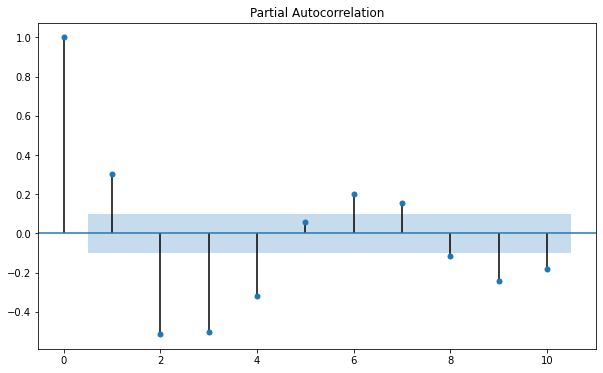

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot=plot_pacf(xe,lags=10)

선이 파란색 영역안에 있을 때 계산이 진행되고 선상 자동 상관 값은 AR 값을 계산하는데 사용된다.

합계가 ARIMA 모델의 AR 값이 되는 것이다.

AR = 3

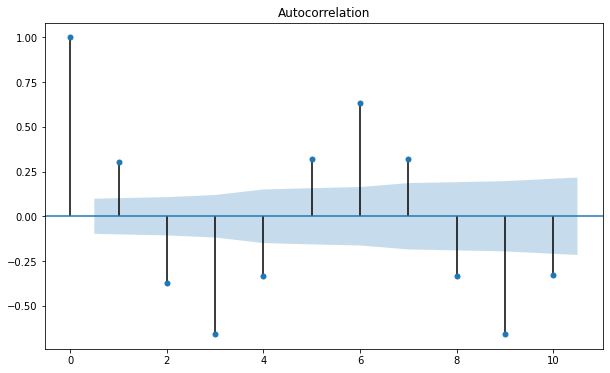

In [25]:
acf_plot=plot_acf(xe,lags=10)

이동 평균은 자기 상관을 사용하여 계산 (파란색 영역 위에 있으면 MA로 계산)

MA = 3

In [26]:
xtrain=xe[0:330]
xtest=xe[330:397]

In [27]:
len(xtrain)

330

In [28]:
xtrain.head()

1985-01-01    72.5052
1985-02-01    -1.8332
1985-03-01    -8.2218
1985-04-01    -4.9788
1985-05-01    -2.1563
dtype: float64

In [29]:
from statsmodels.tsa.arima_model import ARIMA

In [30]:
xee=ARIMA(xtrain,order=(3,0,3))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [31]:
ttt=xee.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: Converge

In [32]:
ttt.aic

2023.85575709453

In [33]:
tt=ttt.forecast(steps=67)[0]

In [34]:
tt[:10]

array([  8.40748265,  -4.32442026, -12.00586392,  -7.61187122,
         4.45343605,  12.10796739,   7.68655925,  -4.38323858,
       -12.01486312,  -7.56608957])

In [35]:
xtest.values[:10]

array([ 11.8957,  -3.1756, -13.117 ,  -6.3626,   3.9612,  10.9305,
        10.2288,  -8.767 ,  -3.7392, -11.9856])

In [36]:
xtest[0]

11.895700000000005

In [37]:
qqq=[]
a=0
for i in range(330):
    a=a+xtrain[i]
    qqq.append(a)

In [38]:
train["IPG2211A2N"].iloc[335]

105.2722

In [39]:
qqq[329]

101.14